In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group
from typing import Dict, Tuple

import xgboost as xgb

from src.data_generation import *
from src.analysis import ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts

from src.robust_training.mechanistic import MechanisticTrainer
from src.robust_training.mechanistic import run_mechanistic_robust_training_and_eval_in_memory
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

np.random.seed(0)

GRID_SEARCH = False
PLOT = False
GEN_DATA = True



In [23]:
def evaluate_GBC(model, df_dict: Dict[float, pd.DataFrame], target: str) -> float:
    """
    Calculate mean AUC across all shift levels in df_dict.
    """
    aucs = []
    for _, df_shifted in df_dict.items():
        X_test = df_shifted.drop(columns=[target])
        y_test = df_shifted[target]
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_proba))
        except:
            # If model doesn't support `predict_proba`, skip
            continue
    return np.mean(aucs)

def evaluate_model_final(model, final_test_df: pd.DataFrame, target: str) -> float:
    """
    Calculate AUC specifically on the final test set (here assumed mix=1.0).
    """
    X_test = final_test_df.drop(columns=[target])
    y_test = final_test_df[target]
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        return roc_auc_score(y_test, y_proba)
    except:
        return 0.0

def build_df_dict(
    num_samples: int,
    mean_train: np.ndarray,
    covariance_train: np.ndarray,
    df_train: pd.DataFrame,
    num_features: int = 3,
    degree: int = 2,
    mix_probs = None,
    random_state: int = 42,
    known_coef: np.ndarray = None
) -> Dict[float, pd.DataFrame]:
    """
    Generate a dictionary of shifted test sets for multiple mix probabilities.
    Returns {mix_prob: DataFrame}.
    """
    if mix_probs is None:
        mix_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 
                     0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    np.random.seed(random_state)
    
    # Shift parameters (you can customize the quantile or random_cov range)
    mean_shift = attributes_quantile(df_train, 0.05)
    covariance_shift = random_cov(num_features, low=-0.5, high=0.5)
    
    df_dict = {}
    for mix_prob in mix_probs:
        sample_mix = build_mixture_sample(
            num_samples, 
            mean_train, covariance_train, 
            mean_shift, covariance_shift, 
            mix_prob=mix_prob
        )
        df_mix = pd.DataFrame(sample_mix, columns=[f"X{i+1}" for i in range(num_features)])
        
        # Use known_coef if you want consistent polynomials across train & test
        if known_coef is not None:
            y_mix, z_mix, _ = build_poly_target(sample_mix, degree, coefficients=known_coef)
        else:
            y_mix, z_mix, _ = build_poly_target(sample_mix, degree)
        
        df_mix["Y"] = y_mix
        df_mix["Z"] = z_mix
        df_dict[mix_prob] = df_mix
    
    return df_dict

def paired_t_test(robust_scores, baseline_scores, alpha=0.05):
    """
    Conduct a paired t-test for robust_scores vs baseline_scores.
    Returns: (mean_diff, t_stat, p_val, (ci_lower, ci_upper))
    """
    diffs = robust_scores - baseline_scores
    n = len(diffs)
    mean_diff = np.mean(diffs)
    var_diff = np.var(diffs, ddof=1)
    se_diff = np.sqrt(var_diff / n)
    t_stat = mean_diff / se_diff
    
    p_val = 2.0 * (1.0 - st.t.cdf(abs(t_stat), df=n-1))
    
    t_crit = st.t.ppf(1 - alpha / 2, df=n-1)
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff
    
    return mean_diff, t_stat, p_val, (ci_lower, ci_upper)


In [26]:
np.random.seed(0)
num_samples = 10000
num_features = 3
degree = 2  # polynomial degree

# Training data mean & covariance
mean_train = np.array([0.90920214, 0.81962487, 0.88819135])
covariance_train = np.array([
    [0.726318,     0.20240102,  0.52472545],
    [0.20240102,   0.11392557,  0.0264108 ],
    [0.52472545,   0.0264108,   1.05107627]
])

# Generate training set
sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
df_train = pd.DataFrame(sample_train, columns=[f"X{i+1}" for i in range(num_features)])

# Polynomial coefficients for target generation (optional, known for consistency)
coef = [
    -0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 
    0.4803476403769713, -0.10624889645240687, 0.3182084398201366, 
    0.6789895126695962, -0.791324832566177,   0.531479159887424, 
    0.49115959567000167
]
y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
df_train["Y"] = y_train
df_train["Z"] = z_train


In [ ]:
N = 50  
all_iterations_results = []

for iteration in range(1, N + 1):
    print(f"\n{'='*30}")
    print(f"  Iteration {iteration}/{N}")
    print(f"{'='*30}")
    
    
    df_dict = build_df_dict(
        num_samples=num_samples,
        mean_train=mean_train,
        covariance_train=covariance_train,
        df_train=df_train,
        num_features=num_features,
        degree=degree,
        random_state=iteration,   
        known_coef=coef_train
    )
    
    baseline_model, robust_model = run_mechanistic_robust_training_and_eval_in_memory(
        df_train=df_train,
        df_dict=df_dict,
        target='Y',
        base_shift_factor=  list(np.random.uniform(0.015, 0.075, 10)),         
        fraction_to_shift=0.8,          
        model_type='gbc',
        random_state=iteration,
        n_rounds=1,
        noise_scale=0.0
    )
    
   
    overall_baseline_score = evaluate_GBC(baseline_model, df_dict, 'Y')
    overall_robust_score   = evaluate_GBC(robust_model, df_dict, 'Y')
    
    
    final_test_df = df_dict[1.0]
    final_baseline_auc = evaluate_model_final(baseline_model, final_test_df, 'Y')
    final_robust_auc   = evaluate_model_final(robust_model, final_test_df, 'Y')
   
    all_iterations_results.append({
        "iteration": iteration,
        "overall_baseline_score": overall_baseline_score,
        "overall_robust_score": overall_robust_score,
        "final_baseline_auc": final_baseline_auc,
        "final_robust_auc": final_robust_auc
    })


  Iteration 1/50
Training set shape = (10000, 4);  Target distribution:
Y
1    5495
0    4505
Name: count, dtype: int64

=== Training Baseline Model ===
=> Baseline model trained.

=== Training Robust Model ===
[MechanisticTrainer] Augmentation Round 1/1
  => Augmenting 10000 samples.
  => Augmented pool size: 20000 samples
  => Downsampled combined data to 10000 total samples.
[MechanisticTrainer] Robust model training completed.

=> Robust model trained.

=== Evaluation on Shifted Datasets ===

Shift = 0.0
  Baseline => Accuracy: 0.788, F1: 0.802, AUC: 0.872
  Robust   => Accuracy: 0.786, F1: 0.800, AUC: 0.870
  Delta AUC (Robust - Baseline) = -0.0018

Shift = 0.1
  Baseline => Accuracy: 0.772, F1: 0.776, AUC: 0.852
  Robust   => Accuracy: 0.766, F1: 0.772, AUC: 0.850
  Delta AUC (Robust - Baseline) = -0.0020

Shift = 0.2
  Baseline => Accuracy: 0.764, F1: 0.759, AUC: 0.848
  Robust   => Accuracy: 0.761, F1: 0.757, AUC: 0.847
  Delta AUC (Robust - Baseline) = -0.0015

Shift = 0.3
  


Saved results to robust_vs_baseline_results.csv

   iteration  overall_baseline_score  overall_robust_score  \
0          1                0.805842              0.801520   
1          2                0.766836              0.769771   
2          3                0.751236              0.760574   
3          4                0.791391              0.776400   
4          5                0.762267              0.756404   

   final_baseline_auc  final_robust_auc  
0            0.704839          0.693723  
1            0.619345          0.627963  
2            0.562501          0.592040  
3            0.683526          0.646848  
4            0.594995          0.585928  
===== Paired t-Test (Overall AUC) =====
Mean Difference (Robust - Baseline): -0.0017
T-statistic: -1.5102, p-value: 0.13741
95% CI: [-0.0041, 0.0006]

===== Paired t-Test (Final AUC) =====
Mean Difference (Robust - Baseline): -0.0011
T-statistic: -0.3351, p-value: 0.73894
95% CI: [-0.0075, 0.0054]



C:\Users\giaco\AppData\Local\Temp\ipykernel_23716\3479419085.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


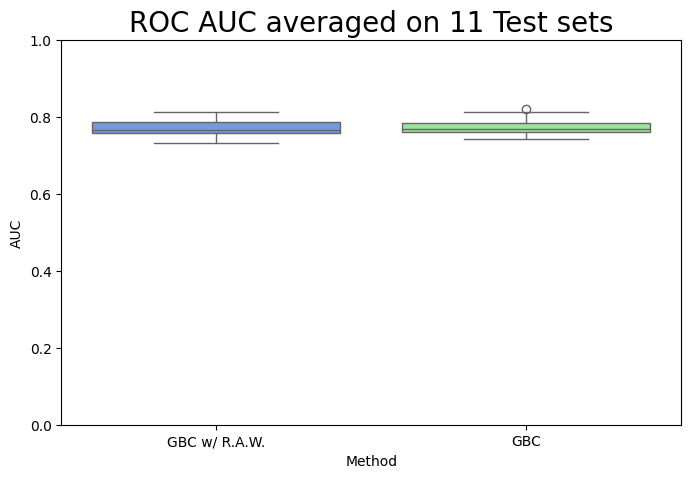

C:\Users\giaco\AppData\Local\Temp\ipykernel_23716\3479419085.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


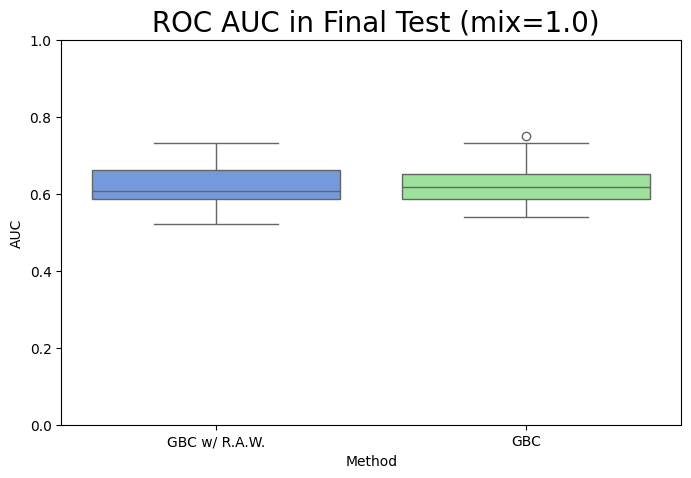

C:\Users\giaco\AppData\Local\Temp\ipykernel_23716\3479419085.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diff_overall, width=0.5, palette="magma")


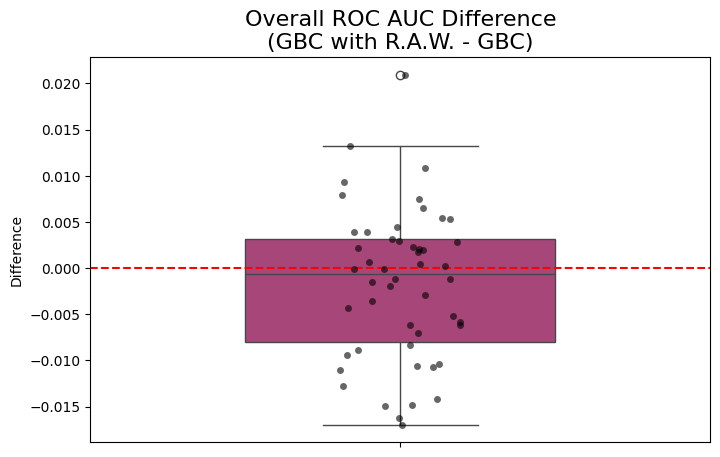

C:\Users\giaco\AppData\Local\Temp\ipykernel_23716\3479419085.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=diff_final, width=0.5, palette="viridis")


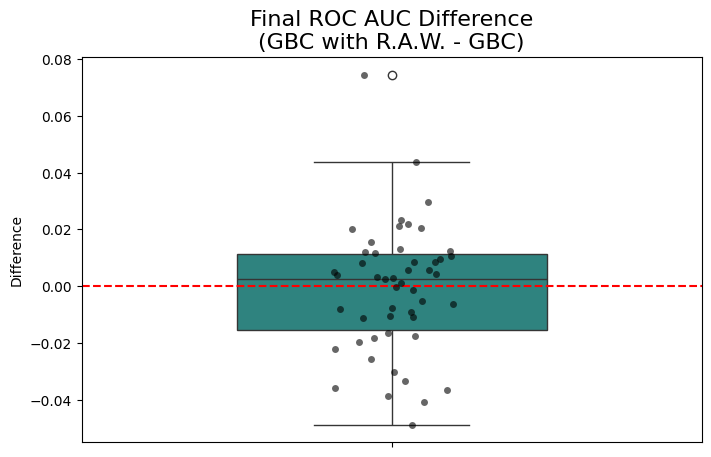

In [35]:
df_results = pd.DataFrame(all_iterations_results)
csv_path = "robust_vs_baseline_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"\nSaved results to {csv_path}\n")
print(df_results.head())

# 1) Paired t-test for Overall AUC
overall_robust = df_results["overall_robust_score"].values
overall_baseline = df_results["overall_baseline_score"].values
mean_diff_overall, t_overall, p_overall, ci_overall = paired_t_test(
    overall_robust, overall_baseline
)

print("===== Paired t-Test (Overall AUC) =====")
print(f"Mean Difference (Robust - Baseline): {mean_diff_overall:.4f}")
print(f"T-statistic: {t_overall:.4f}, p-value: {p_overall:.5f}")
print(f"95% CI: [{ci_overall[0]:.4f}, {ci_overall[1]:.4f}]")

# 2) Paired t-test for Final AUC (mix=1.0)
final_robust = df_results["final_robust_auc"].values
final_baseline = df_results["final_baseline_auc"].values
mean_diff_final, t_final, p_final, ci_final = paired_t_test(
    final_robust, final_baseline
)

print("\n===== Paired t-Test (Final AUC) =====")
print(f"Mean Difference (Robust - Baseline): {mean_diff_final:.4f}")
print(f"T-statistic: {t_final:.4f}, p-value: {p_final:.5f}")
print(f"95% CI: [{ci_final[0]:.4f}, {ci_final[1]:.4f}]\n")

# Prepare data for boxplots
df_plot_overall = pd.DataFrame({
    'AUC': np.concatenate([overall_robust, overall_baseline]),
    'Method': ['GBC w/ R.A.W.'] * len(overall_robust) + ['GBC'] * len(overall_baseline),
    'Scenario': ['Overall'] * (2 * len(overall_robust))
})

df_plot_final = pd.DataFrame({
    'AUC': np.concatenate([final_robust, final_baseline]),
    'Method': ['GBC w/ R.A.W.'] * len(final_robust) + ['GBC'] * len(final_baseline),
    'Scenario': ['Final'] * (2 * len(final_robust))
})

df_plot_all = pd.concat([df_plot_overall, df_plot_final], ignore_index=True)

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_plot_all[df_plot_all["Scenario"] == "Overall"],
    x="Method", y="AUC", 
    palette=["cornflowerblue", "lightgreen"]
)
plt.title("ROC AUC averaged on 11 Test sets", fontsize=20)
plt.ylim(0.0, 1.0)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_plot_all[df_plot_all["Scenario"] == "Final"],
    x="Method", y="AUC",
    palette=["cornflowerblue", "lightgreen"]
)
plt.title(" ROC AUC in Final Test (mix=1.0)", fontsize=20)
plt.ylim(0.0, 1.0)
plt.show()


diff_overall = overall_robust - overall_baseline
diff_final = final_robust - final_baseline

plt.figure(figsize=(8, 5))
sns.boxplot(data=diff_overall, width=0.5, palette="magma")
sns.stripplot(data=diff_overall, color='black', size=5, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Overall ROC AUC Difference\n(GBC with R.A.W. - GBC)", fontsize=16)
plt.ylabel("Difference")
plt.show()
 
plt.figure(figsize=(8, 5))
sns.boxplot(data=diff_final, width=0.5, palette="viridis")
sns.stripplot(data=diff_final, color='black', size=5, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Final ROC AUC Difference\n(GBC with R.A.W. - GBC)", fontsize=16)
plt.ylabel("Difference") 
plt.show()